# Plotting features from several similar label images by mimicking a timelapse structure
This notebook shows an example of how to plot features from several similar label images (same shape) at the same plot by turning them into a stack that mimics a timalapse shape (t, z, y, x) and by concatenating tables adding a `frame` column.

In [1]:
import napari
from napari.utils import nbscreenshot
from skimage import data
import numpy as np
from skimage import measure, filters
import pandas as pd
from napari_skimage_regionprops import add_table

from napari_clusters_plotter._plotter import PlotterWidget

## Load sample data

In [2]:
image = data.human_mitosis()
nrows, ncols = image.shape

## Split data to have 4 different images with the same shape

In [3]:
image1 = image[:nrows//2, :ncols//2]
image2 = image[:nrows//2, ncols//2:]
image3 = image[nrows//2:, :ncols//2]
image4 = image[nrows//2:, ncols//2:]
image_list = [image1, image2, image3, image4]

## Create label images from intensity images

In [4]:
labels_list = []
for image in image_list:
    filtered = filters.gaussian(image, 1)
    th = filters.threshold_otsu(filtered)
    binary = filtered > th
    labels = measure.label(binary)
    labels_list.append(labels)

## Feature Extraction
Also add frame column to mimic a timalpse table

In [5]:
tables_list = []
for labels, image, i in zip(labels_list, image_list, range(len(image_list))):
    table = pd.DataFrame(measure.regionprops_table(labels, image, properties=['label', 
                                                                                'area', 
                                                                                'axis_major_length', 
                                                                                'axis_major_length', 
                                                                                'feret_diameter_max', 
                                                                                'orientation', 
                                                                                'solidity', 
                                                                                'eccentricity', 
                                                                                'intensity_mean',
    ]))
    table['frame'] = i
    tables_list.append(table)

Concatenate tables

In [6]:
master_table = pd.concat(tables_list)
master_table

,label,area,axis_major_length,feret_diameter_max,orientation,solidity,eccentricity,intensity_mean,frame
0,1,64,10.862780,10.770330,1.570796,1.000000,0.713074,50.250000,0
1,2,73,12.568236,13.000000,0.507038,0.935897,0.808680,59.054795,0
2,3,77,11.542712,11.704700,0.041654,0.987179,0.680056,52.558442,0
3,4,86,11.624222,12.083046,-1.391353,0.945055,0.570413,47.790698,0
4,5,137,13.928775,14.866069,1.338121,0.951389,0.435103,56.416058,0
...,...,...,...,...,...,...,...,...,...
124,125,94,12.501291,13.000000,1.429126,0.969072,0.633197,75.191489,3
125,126,66,11.105378,12.083046,1.361233,0.916667,0.699711,81.575758,3
126,127,46,12.025488,12.369317,-1.375409,0.920000,0.903905,73.630435,3
127,128,41,10.016467,10.198039,1.551212,0.953488,0.843950,57.243902,3


## Stack labels

In [7]:
labels_stack = np.stack(labels_list)
labels_stack = labels_stack[:, np.newaxis]
labels_stack.shape

(4, 1, 256, 256)

## Open in napari

In [8]:
viewer = napari.Viewer()
labels_layer = viewer.add_labels(labels_stack, features = master_table)

In [9]:
add_table(labels_layer, viewer)

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


## Visualize features from overlaid label images with the clusters-plotter

In [10]:
widget = PlotterWidget(viewer)
viewer.window.add_dock_widget(widget)

`Update measurements` and then plot two features using the plugin.

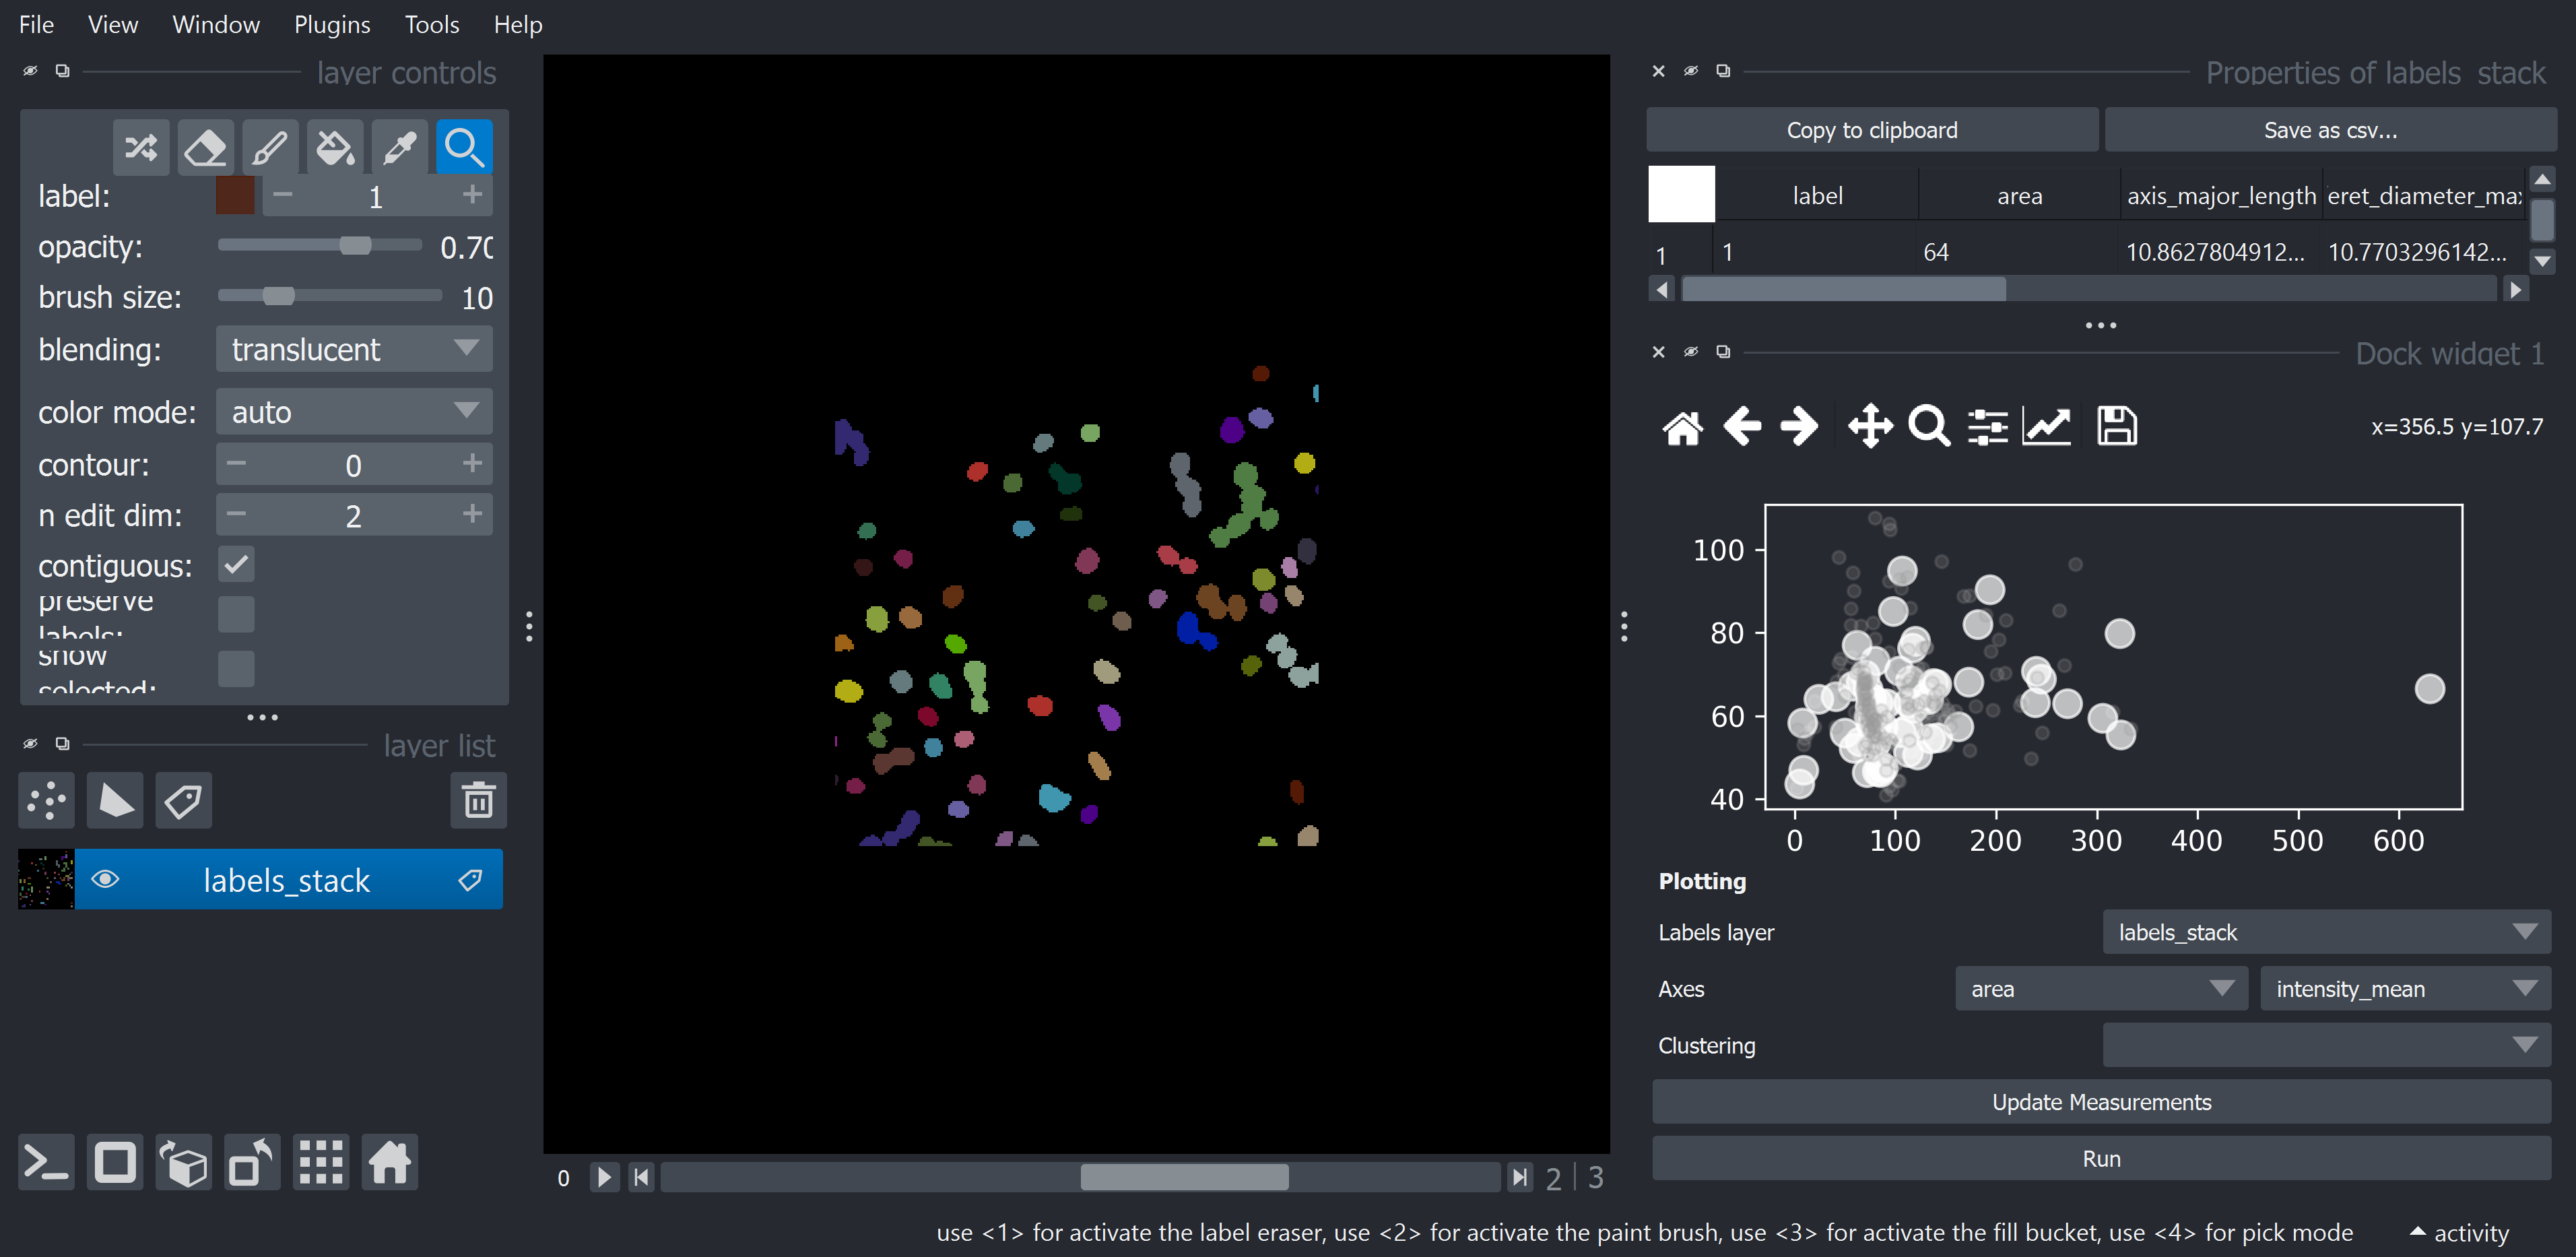

In [11]:
nbscreenshot(viewer)